In [ ]:
%%writefile crt_calc.py
import pandas as pd
from dataclasses import dataclass
from typing import Optional, Iterable

BST_MIS_2025_RO_PER_MWH = {
    "Jan-Mar": {"OP": 12, "NP": 12, "WDP": 12, "WEDP": 12},
    "Apr":     {"OP": 16, "NP": 16, "WDP": 16, "WEDP": 16},
    "May-Jul": {"OP": 19, "NP": 46, "WDP": 36, "WEDP": 28},
    "Aug-Sep": {"OP": 17, "NP": 27, "WDP": 20, "WEDP": 20},
    "Oct":     {"OP": 16, "NP": 16, "WDP": 16, "WEDP": 16},
    "Nov-Dec": {"OP": 12, "NP": 12, "WDP": 12, "WEDP": 12},
}

DIST_BZ_PER_KWH = {"33kV": 4.0, "11kV": 5.0, "0.415kV": 10.6}
CAPACITY_OMR_PER_MW_YEAR = {"CGR": 6775, "CPR": 7691, "NCPR": 1839}

SUPPLY_CHARGE_OMR_PER_YEAR = 50
VAT_RATE = 0.05


def month_block(m: int) -> str:
    if m in (1, 2, 3):
        return "Jan-Mar"
    if m == 4:
        return "Apr"
    if m in (5, 6, 7):
        return "May-Jul"
    if m in (8, 9):
        return "Aug-Sep"
    if m == 10:
        return "Oct"
    if m in (11, 12):
        return "Nov-Dec"
    raise ValueError("Invalid month")


def tou_band(ts: pd.Timestamp) -> str:
    hm = ts.hour * 60 + ts.minute

    # pandas: Mon=0 ... Sun=6
    # Oman weekend is typically Fri (4) and Sat (5)
    dow = ts.dayofweek
    is_weekend = dow in (4, 5)

    # Night: 22:00 -> 02:59 (as per your logic)
    if hm >= 22 * 60 or hm <= 2 * 60 + 59:
        return "NP"

    # Midday peak: 13:00 -> 15:59, weekend vs weekday split
    if 13 * 60 <= hm <= 15 * 60 + 59:
        return "WEDP" if is_weekend else "WDP"

    # Off-peak (your definition): 03:00–12:59 and 16:00–21:59
    if (3 * 60 <= hm <= 12 * 60 + 59) or (16 * 60 <= hm <= 21 * 60 + 59):
        return "OP"

    return "OP"


def dist_ro_per_mwh(voltage_level: str) -> float:
    if voltage_level not in DIST_BZ_PER_KWH:
        raise ValueError(f"voltage_level must be one of {list(DIST_BZ_PER_KWH)}")
    # NOTE: despite variable name, you’re treating this as RO/MWh adder in your model.
    return float(DIST_BZ_PER_KWH[voltage_level])


def omr_per_kw_month_from_omr_per_mw_year(x_omr_per_mw_year: float) -> float:
    return x_omr_per_mw_year / 12000.0


@dataclass
class CRTResult:
    tou_energy_omr: float
    capacity_omr: float
    supply_omr: float
    subtotal_omr: float
    vat_omr: float
    total_bill_omr: float


def calculate_crt_option1_2025_mis(
    df: pd.DataFrame,
    voltage_level: str,
    tuos_energy_adder_omr_per_mwh: float = 0.0,
    dc_kw: float = 0.0,
    dnc_kw: float = 0.0,
    include_cgr: bool = True,
    triad_timestamps: Optional[Iterable[pd.Timestamp]] = None,
    timestamp_format: str = "%m/%d/%y %H:%M",
    enforce_single_month: bool = False,
) -> CRTResult:
    """
    Expects df with columns:
      - timestamp (string or datetime)
      - kwh (hourly energy if hourly data)
    Optional:
      - kw (if not provided, assumes hourly and sets kw = kwh)
    """

    required = {"timestamp", "kwh"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"df missing required columns: {missing}")

    dfx = df.copy()

    # ✅ Deterministic timestamp parsing (your file: '1/1/13 0:00')
    if not pd.api.types.is_datetime64_any_dtype(dfx["timestamp"]):
        dfx["timestamp"] = pd.to_datetime(
            dfx["timestamp"],
            format=timestamp_format,
            errors="raise",
            cache=True,
        )
    else:
        # normalize just in case tz/format issues exist
        dfx["timestamp"] = pd.to_datetime(dfx["timestamp"])

    # ✅ Sort for correct diff checks + max demand
    dfx = dfx.sort_values("timestamp").reset_index(drop=True)

    # ✅ Validate strictly-hourly before assuming kW = kWh
    d = dfx["timestamp"].diff().dropna()
    if not d.empty and not (d == pd.Timedelta(hours=1)).all():
        raise ValueError("Data is not strictly hourly. Cannot assume kW = kWh safely.")

    # ✅ Optional: enforce single billing month (prevents accidental multi-month bill)
    if enforce_single_month:
        months = dfx["timestamp"].dt.to_period("M").unique()
        if len(months) != 1:
            raise ValueError(
                f"df contains multiple months ({len(months)}). "
                "Pass a single month or use the monthly wrapper."
            )

    # ✅ If kw is missing, assume hourly: average kW over hour == kWh for that hour
    if "kw" not in dfx.columns:
        dfx["kw"] = dfx["kwh"].astype(float)
    else:
        dfx["kw"] = dfx["kw"].astype(float)

    # Triad override for dc_kw (if provided)
    if triad_timestamps is not None:
        triad_set = set(pd.to_datetime(list(triad_timestamps)))
        triad_rows = dfx[dfx["timestamp"].isin(triad_set)]
        if triad_rows.empty:
            raise ValueError("No rows matched triad_timestamps in df['timestamp']")
        dc_kw = float(triad_rows["kw"].mean())

    # Non-coincident peak (max kW) if not provided
    if dnc_kw == 0.0:
        dnc_kw = float(dfx["kw"].max())

    dv = dist_ro_per_mwh(voltage_level)

    def bst_rate(ts: pd.Timestamp) -> float:
        blk = month_block(ts.month)
        band = tou_band(ts)
        return BST_MIS_2025_RO_PER_MWH[blk][band]

    dfx["bst_ro_per_mwh"] = dfx["timestamp"].apply(bst_rate)
    dfx["mwh"] = dfx["kwh"].astype(float) / 1000.0

    dfx["energy_rate_ro_per_mwh"] = dfx["bst_ro_per_mwh"] + tuos_energy_adder_omr_per_mwh + dv
    tou_energy_omr = float((dfx["mwh"] * dfx["energy_rate_ro_per_mwh"]).sum())

    cpr_kw_month = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["CPR"])
    ncpr_kw_month = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["NCPR"])
    cgr_kw_month = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["CGR"])

    capacity_omr = dc_kw * cpr_kw_month + dnc_kw * ncpr_kw_month
    if include_cgr:
        capacity_omr += dc_kw * cgr_kw_month

    supply_omr = SUPPLY_CHARGE_OMR_PER_YEAR / 12.0
    subtotal_omr = tou_energy_omr + capacity_omr + supply_omr
    vat_omr = subtotal_omr * VAT_RATE
    total_bill_omr = subtotal_omr + vat_omr

    return CRTResult(
        tou_energy_omr=tou_energy_omr,
        capacity_omr=capacity_omr,
        supply_omr=supply_omr,
        subtotal_omr=subtotal_omr,
        vat_omr=vat_omr,
        total_bill_omr=total_bill_omr,
    )


def calculate_monthly_bills_option1_2025_mis(df: pd.DataFrame, voltage_level: str, **kwargs) -> pd.DataFrame:
    """
    Convenience wrapper: returns a DataFrame with monthly CRT bills.
    Expects df with timestamp + kwh (and optional kw).
    """
    dfx = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(dfx["timestamp"]):
        dfx["timestamp"] = pd.to_datetime(
            dfx["timestamp"],
            format=kwargs.pop("timestamp_format", "%m/%d/%y %H:%M"),
            errors="raise",
            cache=True,
        )
    dfx = dfx.sort_values("timestamp").reset_index(drop=True)
    dfx["month"] = dfx["timestamp"].dt.to_period("M")

    rows = []
    for m, g in dfx.groupby("month"):
        res = calculate_crt_option1_2025_mis(g.drop(columns=["month"]), voltage_level=voltage_level, **kwargs)
        rows.append(
            {
                "month": str(m),
                "tou_energy_omr": res.tou_energy_omr,
                "capacity_omr": res.capacity_omr,
                "supply_omr": res.supply_omr,
                "subtotal_omr": res.subtotal_omr,
                "vat_omr": res.vat_omr,
                "total_bill_omr": res.total_bill_omr,
            }
        )

    return pd.DataFrame(rows)


Overwriting crt_calc.py


In [ ]:
%%writefile test_crt.py
import pandas as pd
import numpy as np

from crt_calc import (
    calculate_crt_option1_2025_mis,
    BST_MIS_2025_RO_PER_MWH,
    CAPACITY_OMR_PER_MW_YEAR,
    SUPPLY_CHARGE_OMR_PER_YEAR,
    VAT_RATE,
    dist_ro_per_mwh,
    omr_per_kw_month_from_omr_per_mw_year,
)

def reference_calc_option1_2025_mis(
    df: pd.DataFrame,
    voltage_level: str,
    tuos_energy_adder_omr_per_mwh: float = 0.0,
    dc_kw: float = 0.0,
    dnc_kw: float = 0.0,
    include_cgr: bool = True,
    triad_timestamps=None,
    timestamp_format: str = "%m/%d/%y %H:%M",
):
    dfx = df.copy()

    # ✅ Deterministic parsing if strings (matches prod intent)
    if not pd.api.types.is_datetime64_any_dtype(dfx["timestamp"]):
        dfx["timestamp"] = pd.to_datetime(
            dfx["timestamp"],
            format=timestamp_format,
            errors="raise",
            cache=True
        )
    else:
        dfx["timestamp"] = pd.to_datetime(dfx["timestamp"])

    dfx["kwh"] = dfx["kwh"].astype(float)

    if "kw" not in dfx.columns:
        dfx["kw"] = dfx["kwh"].astype(float)
    else:
        dfx["kw"] = dfx["kw"].astype(float)

    # demand bases
    if triad_timestamps is not None:
        triad_set = set(pd.to_datetime(list(triad_timestamps)))
        triad_rows = dfx[dfx["timestamp"].isin(triad_set)]
        if triad_rows.empty:
            raise ValueError("No rows matched triad_timestamps in df['timestamp']")
        dc_kw = float(triad_rows["kw"].mean())

    if dnc_kw == 0.0:
        dnc_kw = float(dfx["kw"].max())

    ts = dfx["timestamp"]
    hm = ts.dt.hour * 60 + ts.dt.minute
    dow = ts.dt.dayofweek
    is_weekend = dow.isin([4, 5])  # Fri, Sat

    band = np.full(len(dfx), "OP", dtype=object)
    night = (hm >= 22*60) | (hm <= 2*60 + 59)
    band[night] = "NP"
    daypeak = (hm >= 13*60) & (hm <= 15*60 + 59)
    band[daypeak & is_weekend.to_numpy()] = "WEDP"
    band[daypeak & (~is_weekend).to_numpy()] = "WDP"
    dfx["tou_band"] = band

    m = ts.dt.month
    season = np.full(len(dfx), "", dtype=object)
    season[np.isin(m, [1,2,3])] = "Jan-Mar"
    season[m == 4] = "Apr"
    season[np.isin(m, [5,6,7])] = "May-Jul"
    season[np.isin(m, [8,9])] = "Aug-Sep"
    season[m == 10] = "Oct"
    season[np.isin(m, [11,12])] = "Nov-Dec"
    dfx["season_block"] = season

    # lookup BST
    rows = []
    for s, bands in BST_MIS_2025_RO_PER_MWH.items():
        for b, rate in bands.items():
            rows.append((s, b, float(rate)))
    bst_lookup = pd.DataFrame(rows, columns=["season_block", "tou_band", "bst_ro_per_mwh"])
    dfx = dfx.merge(bst_lookup, on=["season_block", "tou_band"], how="left")

    if dfx["bst_ro_per_mwh"].isna().any():
        raise ValueError("Missing BST mapping for some rows")

    dv = dist_ro_per_mwh(voltage_level)
    dfx["mwh"] = dfx["kwh"] / 1000.0
    dfx["energy_rate_ro_per_mwh"] = dfx["bst_ro_per_mwh"] + tuos_energy_adder_omr_per_mwh + dv
    tou_energy_omr = float((dfx["mwh"] * dfx["energy_rate_ro_per_mwh"]).sum())

    cpr_kw_month = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["CPR"])
    ncpr_kw_month = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["NCPR"])
    cgr_kw_month = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["CGR"])

    capacity_omr = dc_kw * cpr_kw_month + dnc_kw * ncpr_kw_month
    if include_cgr:
        capacity_omr += dc_kw * cgr_kw_month

    supply_omr = SUPPLY_CHARGE_OMR_PER_YEAR / 12.0
    subtotal_omr = tou_energy_omr + capacity_omr + supply_omr
    vat_omr = subtotal_omr * VAT_RATE
    total_bill_omr = subtotal_omr + vat_omr

    return {
        "tou_energy_omr": tou_energy_omr,
        "capacity_omr": capacity_omr,
        "supply_omr": supply_omr,
        "subtotal_omr": subtotal_omr,
        "vat_omr": vat_omr,
        "total_bill_omr": total_bill_omr,
    }

def assert_close(a, b, tol=1e-6, label=""):
    if abs(a-b) > tol:
        raise AssertionError(f"{label} mismatch: a={a}, b={b}, diff={a-b}")

def run_golden_tests():
    print("Running golden tests...")

    df = pd.DataFrame({
        "timestamp": pd.date_range("2025-06-01 00:00:00", periods=24, freq="h"),
        "kwh": [100.0]*24,
        "kw":  [100.0]*24,
    })

    params = dict(
        df=df,
        voltage_level="11kV",
        tuos_energy_adder_omr_per_mwh=0.0,
        dc_kw=500.0,
        dnc_kw=900.0,
        include_cgr=True,
        triad_timestamps=None,
        timestamp_format="%m/%d/%y %H:%M",
        enforce_single_month=False,
    )

    prod = calculate_crt_option1_2025_mis(**params)
    ref  = reference_calc_option1_2025_mis(
        df=df,
        voltage_level="11kV",
        tuos_energy_adder_omr_per_mwh=0.0,
        dc_kw=500.0,
        dnc_kw=900.0,
        include_cgr=True,
        triad_timestamps=None,
        timestamp_format="%m/%d/%y %H:%M",
    )

    assert_close(prod.tou_energy_omr, ref["tou_energy_omr"], label="tou_energy_omr")
    assert_close(prod.capacity_omr,   ref["capacity_omr"],   label="capacity_omr")
    assert_close(prod.supply_omr,     ref["supply_omr"],     label="supply_omr")
    assert_close(prod.subtotal_omr,   ref["subtotal_omr"],   label="subtotal_omr")
    assert_close(prod.vat_omr,        ref["vat_omr"],        label="vat_omr")
    assert_close(prod.total_bill_omr, ref["total_bill_omr"], label="total_bill_omr")

    print("✅ golden_test_sample_day passed\n")

def run_fuzz_tests(n=200, seed=42):
    print(f"Running fuzz tests (n={n})...")
    rng = np.random.default_rng(seed)

    for i in range(n):
        start_month = int(rng.integers(1, 13))
        start = pd.Timestamp(year=2025, month=start_month, day=1, hour=0)
        periods = 24*7

        df = pd.DataFrame({
            "timestamp": pd.date_range(start, periods=periods, freq="h"),
            "kwh": rng.uniform(0, 300, size=periods),
        })
        if rng.random() < 0.7:
            df["kw"] = df["kwh"]

        params = dict(
            df=df,
            voltage_level=str(rng.choice(["33kV","11kV","0.415kV"])),
            tuos_energy_adder_omr_per_mwh=float(rng.choice([0.0, 1.5, 3.0])),
            dc_kw=float(rng.uniform(0, 2000)),
            dnc_kw=float(rng.uniform(0, 3000)),
            include_cgr=bool(rng.choice([True, False])),
            triad_timestamps=None,
            timestamp_format="%m/%d/%y %H:%M",
            enforce_single_month=False,
        )

        prod = calculate_crt_option1_2025_mis(**params)
        ref  = reference_calc_option1_2025_mis(
            df=df,
            voltage_level=params["voltage_level"],
            tuos_energy_adder_omr_per_mwh=params["tuos_energy_adder_omr_per_mwh"],
            dc_kw=params["dc_kw"],
            dnc_kw=params["dnc_kw"],
            include_cgr=params["include_cgr"],
            triad_timestamps=None,
            timestamp_format="%m/%d/%y %H:%M",
        )

        assert_close(prod.total_bill_omr, ref["total_bill_omr"], tol=1e-6, label="total_bill_omr")

    print("✅ fuzz tests passed\n")

if __name__ == "__main__":
    run_golden_tests()
    run_fuzz_tests(300)


Overwriting test_crt.py


In [ ]:
!python test_crt.py


Running golden tests...
✅ golden_test_sample_day passed\n
Running fuzz tests (n=300)...
✅ fuzz tests passed\n


In [ ]:
import pandas as pd
import re

df = pd.read_csv("/content/hourly_data_2013.csv")

df["timestamp"] = pd.to_datetime(
    df["timestamp"],
    format="%m/%d/%y %H:%M",
    errors="raise",
    cache=True
)

df = df.sort_values("timestamp").reset_index(drop=True)

def extract_chiller(df: pd.DataFrame, chiller_num: int) -> pd.DataFrame:
    prefix = f"CP_Chiller{chiller_num}_"
    cols = ["timestamp"] + [c for c in df.columns if c.startswith(prefix)]
    out = df[cols].copy()
    out.columns = ["timestamp"] + [c.replace(prefix, "") for c in out.columns if c != "timestamp"]
    return out

def chiller_to_crt_input(df: pd.DataFrame, chiller_num: int) -> pd.DataFrame:
    ch = extract_chiller(df, chiller_num)

    # ✅ hourly integrity check (must be hourly to assume kWh = kW)
    d = ch["timestamp"].diff().dropna()
    if not d.empty and not (d == pd.Timedelta(hours=1)).all():
        raise ValueError("Chiller data is not strictly hourly. Cannot set kWh = kW.")

    # ✅ locate the kW column after prefix removal
    kw_candidates = [c for c in ch.columns if c.lower() in ("kw", "kW".lower())]  # usually 'kW'
    if "kW" in ch.columns:
        kw_col = "kW"
    elif len([c for c in ch.columns if c.lower() == "kw"]) == 1:
        kw_col = [c for c in ch.columns if c.lower() == "kw"][0]
    else:
        # fallback: any column that ends with 'kW'
        alt = [c for c in ch.columns if c.lower().endswith("kw")]
        if len(alt) == 1:
            kw_col = alt[0]
        else:
            raise ValueError(f"Could not uniquely identify a kW column for chiller {chiller_num}. Found: {alt}")

    out = ch[["timestamp"]].copy()
    out["kw"] = pd.to_numeric(ch[kw_col], errors="coerce")
    out["kwh"] = out["kw"]  # ✅ hourly => kWh per hour equals average kW for that hour

    return out

crt_df_ch1 = chiller_to_crt_input(df, 1)
crt_df_ch1.head()


,timestamp,kw,kwh
0,2013-01-01 00:00:00,0.0,0.0
1,2013-01-01 01:00:00,0.0,0.0
2,2013-01-01 02:00:00,0.0,0.0
3,2013-01-01 03:00:00,0.0,0.0
4,2013-01-01 04:00:00,0.0,0.0


In [ ]:
ch1 = extract_chiller(df, 1)
print(ch1.columns.tolist())

print("Non-zero kW rows:", (crt_df_ch1["kw"] > 0).sum())
print("Max kW:", crt_df_ch1["kw"].max())
print("Mean kW:", crt_df_ch1["kw"].mean())




['timestamp', 'ChilledWaterFlowrate', 'ChilledWaterReturnTemp', 'ChilledWaterSupplyTemp', 'CondenserWaterFlowrate', 'CondenserWaterReturnTemp', 'CondenserWaterSupplyTemp', 'CoolingTons', 'Efficiency', 'kW']
Non-zero kW rows: 2679
Max kW: 321.719
Mean kW: 71.09853926397437


In [ ]:
import pandas as pd
import numpy as np
from typing import Dict, Iterable, Optional, Tuple

def _ensure_hourly_and_kw_kwh(
    df: pd.DataFrame,
    timestamp_format: str = "%m/%d/%y %H:%M",
) -> pd.DataFrame:
    dfx = df.copy()

    # timestamp parse (deterministic for your 2013 format)
    if not pd.api.types.is_datetime64_any_dtype(dfx["timestamp"]):
        dfx["timestamp"] = pd.to_datetime(
            dfx["timestamp"], format=timestamp_format, errors="raise", cache=True
        )
    else:
        dfx["timestamp"] = pd.to_datetime(dfx["timestamp"])

    dfx = dfx.sort_values("timestamp").reset_index(drop=True)

    # hourly validation
    d = dfx["timestamp"].diff().dropna()
    if not d.empty and not (d == pd.Timedelta(hours=1)).all():
        raise ValueError("Data is not strictly hourly. Refuse kW/kWh assumptions.")

    # numeric kwh
    dfx["kwh"] = pd.to_numeric(dfx["kwh"], errors="coerce").astype(float)

    # kw handling
    if "kw" in dfx.columns:
        dfx["kw"] = pd.to_numeric(dfx["kw"], errors="coerce").astype(float)
    else:
        # hourly: avg kW over the hour == kWh for that hour
        dfx["kw"] = dfx["kwh"]

    return dfx


def _compute_dc_kw(
    g: pd.DataFrame,
    method: str = "top_n_peak_bands",
    top_n: int = 3,
    peak_bands: Tuple[str, ...] = ("WDP", "WEDP"),
    triad_timestamps: Optional[Iterable[pd.Timestamp]] = None,
) -> float:
    """
    Coincident peak proxy:
      - method="triad": mean kW over supplied triad_timestamps (exact)
      - method="top_n_peak_bands": mean of top N kW values within peak_bands (default)
      - method="top_n_any": mean of top N kW values over all hours
    """
    if method == "triad":
        if triad_timestamps is None:
            raise ValueError("method='triad' requires triad_timestamps")
        triad_set = set(pd.to_datetime(list(triad_timestamps)))
        triad_rows = g[g["timestamp"].isin(triad_set)]
        if triad_rows.empty:
            raise ValueError("No rows matched triad_timestamps in this month")
        return float(triad_rows["kw"].mean())

    if method == "top_n_any":
        s = g["kw"].dropna()
        if s.empty:
            return 0.0
        return float(s.nlargest(top_n).mean())

    # default: top N within peak bands
    s = g.loc[g["tou_band"].isin(list(peak_bands)), "kw"].dropna()
    if s.empty:
        # fallback: if no peak-band rows exist for some reason, use top_n_any
        s2 = g["kw"].dropna()
        return float(s2.nlargest(top_n).mean()) if not s2.empty else 0.0
    return float(s.nlargest(top_n).mean())


def calculate_monthly_detailed_crt_option1_2025_mis(
    df: pd.DataFrame,
    voltage_level: str,
    tuos_energy_adder_omr_per_mwh: float = 0.0,
    include_cgr: bool = True,
    timestamp_format: str = "%m/%d/%y %H:%M",
    dc_method: str = "top_n_peak_bands",
    dc_top_n: int = 3,
    dc_peak_bands: Tuple[str, ...] = ("WDP", "WEDP"),
    triad_timestamps_by_month: Optional[Dict[str, Iterable[pd.Timestamp]]] = None,
) -> pd.DataFrame:
    """
    Returns a DataFrame where each row is a monthly bill with full CRT breakdown.

    df requires:
      - timestamp
      - kwh
    optional:
      - kw

    Coincident peak (dc_kw):
      - default: mean of top 3 kW values within WDP/WEDP hours each month
      - if you have official triad/system-peak timestamps: pass triad_timestamps_by_month={"2025-06":[...], ...}
        and set dc_method="triad"
    """
    required = {"timestamp", "kwh"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"df missing required columns: {missing}")

    dfx = _ensure_hourly_and_kw_kwh(df, timestamp_format=timestamp_format)

    # TOU band + season block + BST rate
    dfx["tou_band"] = dfx["timestamp"].apply(tou_band)
    dfx["season_block"] = dfx["timestamp"].dt.month.apply(month_block)
    dfx["bst_ro_per_mwh"] = dfx.apply(lambda r: BST_MIS_2025_RO_PER_MWH[r["season_block"]][r["tou_band"]], axis=1)

    # energy quantities
    dfx["mwh"] = dfx["kwh"] / 1000.0

    # adders
    dv_ro_per_mwh = dist_ro_per_mwh(voltage_level)

    # component rates (RO/MWh)
    dfx["rate_bst"] = dfx["bst_ro_per_mwh"]
    dfx["rate_dv"] = dv_ro_per_mwh
    dfx["rate_tuos"] = float(tuos_energy_adder_omr_per_mwh)

    # component costs
    dfx["cost_bst"] = dfx["mwh"] * dfx["rate_bst"]
    dfx["cost_dv"] = dfx["mwh"] * dfx["rate_dv"]
    dfx["cost_tuos"] = dfx["mwh"] * dfx["rate_tuos"]
    dfx["cost_energy_total"] = dfx["cost_bst"] + dfx["cost_dv"] + dfx["cost_tuos"]

    # month key
    dfx["month"] = dfx["timestamp"].dt.to_period("M").astype(str)

    # capacity rates (OMR/kW-month)
    cpr_kw_month  = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["CPR"])
    ncpr_kw_month = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["NCPR"])
    cgr_kw_month  = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["CGR"])

    rows = []
    for month, g in dfx.groupby("month"):
        # kWh by band
        kwh_by_band = g.groupby("tou_band")["kwh"].sum().to_dict()
        # cost by band (total energy cost)
        cost_by_band = g.groupby("tou_band")["cost_energy_total"].sum().to_dict()

        # peaks
        dnc_kw = float(g["kw"].max()) if not g["kw"].dropna().empty else 0.0

        triad_ts = None
        if triad_timestamps_by_month is not None:
            triad_ts = triad_timestamps_by_month.get(month)

        dc_kw = _compute_dc_kw(
            g,
            method=dc_method,
            top_n=dc_top_n,
            peak_bands=dc_peak_bands,
            triad_timestamps=triad_ts,
        )

        # capacity charges
        capacity_cpr  = dc_kw * cpr_kw_month
        capacity_ncpr = dnc_kw * ncpr_kw_month
        capacity_cgr  = (dc_kw * cgr_kw_month) if include_cgr else 0.0
        capacity_total = capacity_cpr + capacity_ncpr + capacity_cgr

        # energy totals
        mwh_total = float(g["mwh"].sum())
        kwh_total = float(g["kwh"].sum())

        cost_bst  = float(g["cost_bst"].sum())
        cost_dv   = float(g["cost_dv"].sum())
        cost_tuos = float(g["cost_tuos"].sum())
        tou_energy_omr = float(g["cost_energy_total"].sum())

        supply_omr = SUPPLY_CHARGE_OMR_PER_YEAR / 12.0
        subtotal_omr = tou_energy_omr + capacity_total + supply_omr
        vat_omr = subtotal_omr * VAT_RATE
        total_bill_omr = subtotal_omr + vat_omr

        rows.append({
            "month": month,

            # energy volumes
            "kwh_total": kwh_total,
            "mwh_total": mwh_total,

            # kWh by TOU band
            "kwh_OP": float(kwh_by_band.get("OP", 0.0)),
            "kwh_NP": float(kwh_by_band.get("NP", 0.0)),
            "kwh_WDP": float(kwh_by_band.get("WDP", 0.0)),
            "kwh_WEDP": float(kwh_by_band.get("WEDP", 0.0)),

            # energy costs by component
            "energy_cost_bst_omr": cost_bst,
            "energy_cost_dv_omr": cost_dv,
            "energy_cost_tuos_omr": cost_tuos,
            "tou_energy_omr": tou_energy_omr,

            # energy cost by TOU band (total)
            "energy_cost_OP_omr": float(cost_by_band.get("OP", 0.0)),
            "energy_cost_NP_omr": float(cost_by_band.get("NP", 0.0)),
            "energy_cost_WDP_omr": float(cost_by_band.get("WDP", 0.0)),
            "energy_cost_WEDP_omr": float(cost_by_band.get("WEDP", 0.0)),

            # demand
            "dc_kw": float(dc_kw),
            "dnc_kw": float(dnc_kw),

            # capacity breakdown
            "capacity_cpr_omr": float(capacity_cpr),
            "capacity_ncpr_omr": float(capacity_ncpr),
            "capacity_cgr_omr": float(capacity_cgr),
            "capacity_omr": float(capacity_total),

            # totals
            "supply_omr": float(supply_omr),
            "subtotal_omr": float(subtotal_omr),
            "vat_omr": float(vat_omr),
            "total_bill_omr": float(total_bill_omr),

            # metadata (for debugging / audit trail)
            "voltage_level": voltage_level,
            "dv_ro_per_mwh": float(dv_ro_per_mwh),
            "tuos_energy_adder_omr_per_mwh": float(tuos_energy_adder_omr_per_mwh),
            "dc_method": dc_method,
            "dc_top_n": int(dc_top_n),
            "dc_peak_bands": ",".join(dc_peak_bands),
            "include_cgr": bool(include_cgr),
        })

    out = pd.DataFrame(rows).sort_values("month").reset_index(drop=True)
    return out


In [ ]:
%%writefile crt_calc.py
# paste the FULL updated crt_calc.py code here


Overwriting crt_calc.py


In [ ]:
import pandas as pd

# 1) Load
df = pd.read_csv("/content/hourly_data_2013.csv")

# 2) Deterministic parse for your format: 1/1/13 0:00
df["timestamp"] = pd.to_datetime(
    df["timestamp"],
    format="%m/%d/%y %H:%M",
    errors="raise",
    cache=True
)

df = df.sort_values("timestamp").reset_index(drop=True)

# 3) Extract one chiller (Chiller 1)
def extract_chiller(df: pd.DataFrame, chiller_num: int) -> pd.DataFrame:
    prefix = f"CP_Chiller{chiller_num}_"
    cols = ["timestamp"] + [c for c in df.columns if c.startswith(prefix)]
    out = df[cols].copy()
    out.columns = ["timestamp"] + [c.replace(prefix, "") for c in out.columns if c != "timestamp"]
    return out

ch1 = extract_chiller(df, 1)

# 4) Build CRT input: timestamp, kw, kwh
crt_df_ch1 = ch1[["timestamp"]].copy()
crt_df_ch1["kw"] = pd.to_numeric(ch1["kW"], errors="coerce").fillna(0.0)

# Hourly data => kWh for each hour = avg kW over that hour
crt_df_ch1["kwh"] = crt_df_ch1["kw"]

# 5) Hourly integrity check (required for kWh=kw assumption)
d = crt_df_ch1["timestamp"].diff().dropna()
if not d.empty and not (d == pd.Timedelta(hours=1)).all():
    raise ValueError("Not strictly hourly -> cannot assume kWh = kW.")

crt_df_ch1.head()


,timestamp,kw,kwh
0,2013-01-01 00:00:00,0.0,0.0
1,2013-01-01 01:00:00,0.0,0.0
2,2013-01-01 02:00:00,0.0,0.0
3,2013-01-01 03:00:00,0.0,0.0
4,2013-01-01 04:00:00,0.0,0.0


In [ ]:
import numpy as np

BST_MIS_2025_RO_PER_MWH = {
    "Jan-Mar": {"OP": 12, "NP": 12, "WDP": 12, "WEDP": 12},
    "Apr":     {"OP": 16, "NP": 16, "WDP": 16, "WEDP": 16},
    "May-Jul": {"OP": 19, "NP": 46, "WDP": 36, "WEDP": 28},
    "Aug-Sep": {"OP": 17, "NP": 27, "WDP": 20, "WEDP": 20},
    "Oct":     {"OP": 16, "NP": 16, "WDP": 16, "WEDP": 16},
    "Nov-Dec": {"OP": 12, "NP": 12, "WDP": 12, "WEDP": 12},
}

DIST_BZ_PER_KWH = {"33kV": 4.0, "11kV": 5.0, "0.415kV": 10.6}
CAPACITY_OMR_PER_MW_YEAR = {"CGR": 6775, "CPR": 7691, "NCPR": 1839}

SUPPLY_CHARGE_OMR_PER_YEAR = 50
VAT_RATE = 0.05

def month_block(m: int) -> str:
    if m in (1,2,3): return "Jan-Mar"
    if m == 4:       return "Apr"
    if m in (5,6,7): return "May-Jul"
    if m in (8,9):   return "Aug-Sep"
    if m == 10:      return "Oct"
    if m in (11,12): return "Nov-Dec"
    raise ValueError("Invalid month")

def tou_band(ts: pd.Timestamp) -> str:
    hm = ts.hour * 60 + ts.minute
    dow = ts.dayofweek  # Mon=0 ... Sun=6
    is_weekend = dow in (4, 5)  # Fri, Sat

    # Night: 22:00 -> 02:59
    if hm >= 22*60 or hm <= 2*60 + 59:
        return "NP"

    # Midday peak: 13:00 -> 15:59
    if 13*60 <= hm <= 15*60 + 59:
        return "WEDP" if is_weekend else "WDP"

    # Off-peak remainder (your definition)
    return "OP"

def dist_ro_per_mwh(voltage_level: str) -> float:
    if voltage_level not in DIST_BZ_PER_KWH:
        raise ValueError(f"voltage_level must be one of {list(DIST_BZ_PER_KWH)}")
    return float(DIST_BZ_PER_KWH[voltage_level])

def omr_per_kw_month_from_omr_per_mw_year(x_omr_per_mw_year: float) -> float:
    return x_omr_per_mw_year / 12000.0

def monthly_detailed_crt_bill(
    df: pd.DataFrame,
    voltage_level: str,
    tuos_energy_adder_omr_per_mwh: float = 0.0,
    include_cgr: bool = True,
    dc_method: str = "top3_peakbands",   # proxy for coincident peak
):
    dfx = df.copy()
    dfx = dfx.sort_values("timestamp").reset_index(drop=True)

    # Required columns
    for col in ("timestamp", "kwh", "kw"):
        if col not in dfx.columns:
            raise ValueError(f"Missing column: {col}")

    dfx["kwh"] = pd.to_numeric(dfx["kwh"], errors="coerce").fillna(0.0)
    dfx["kw"]  = pd.to_numeric(dfx["kw"],  errors="coerce").fillna(0.0)

    # Hourly check
    d = dfx["timestamp"].diff().dropna()
    if not d.empty and not (d == pd.Timedelta(hours=1)).all():
        raise ValueError("Not strictly hourly -> cannot assume kWh = kW.")

    dfx["tou_band"] = dfx["timestamp"].apply(tou_band)
    dfx["season_block"] = dfx["timestamp"].dt.month.apply(month_block)
    dfx["bst_ro_per_mwh"] = dfx.apply(lambda r: BST_MIS_2025_RO_PER_MWH[r["season_block"]][r["tou_band"]], axis=1)

    dfx["mwh"] = dfx["kwh"] / 1000.0
    dv = dist_ro_per_mwh(voltage_level)

    dfx["rate_bst"] = dfx["bst_ro_per_mwh"]
    dfx["rate_dv"] = dv
    dfx["rate_tuos"] = float(tuos_energy_adder_omr_per_mwh)

    dfx["cost_bst"] = dfx["mwh"] * dfx["rate_bst"]
    dfx["cost_dv"] = dfx["mwh"] * dfx["rate_dv"]
    dfx["cost_tuos"] = dfx["mwh"] * dfx["rate_tuos"]
    dfx["cost_energy_total"] = dfx["cost_bst"] + dfx["cost_dv"] + dfx["cost_tuos"]

    dfx["month"] = dfx["timestamp"].dt.to_period("M").astype(str)

    cpr_kw_month  = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["CPR"])
    ncpr_kw_month = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["NCPR"])
    cgr_kw_month  = omr_per_kw_month_from_omr_per_mw_year(CAPACITY_OMR_PER_MW_YEAR["CGR"])

    rows = []
    for month, g in dfx.groupby("month"):
        kwh_by_band = g.groupby("tou_band")["kwh"].sum().to_dict()
        cost_by_band = g.groupby("tou_band")["cost_energy_total"].sum().to_dict()

        dnc_kw = float(g["kw"].max())

        # Coincident peak proxy:
        if dc_method == "top3_peakbands":
            peak = g[g["tou_band"].isin(["WDP", "WEDP"])]["kw"].dropna()
            dc_kw = float(peak.nlargest(3).mean()) if not peak.empty else float(g["kw"].nlargest(3).mean())
        else:
            # fallback: top3 any hour
            dc_kw = float(g["kw"].nlargest(3).mean()) if len(g) else 0.0

        capacity_cpr  = dc_kw * cpr_kw_month
        capacity_ncpr = dnc_kw * ncpr_kw_month
        capacity_cgr  = (dc_kw * cgr_kw_month) if include_cgr else 0.0
        capacity_total = capacity_cpr + capacity_ncpr + capacity_cgr

        tou_energy_omr = float(g["cost_energy_total"].sum())
        supply_omr = SUPPLY_CHARGE_OMR_PER_YEAR / 12.0

        subtotal_omr = tou_energy_omr + capacity_total + supply_omr
        vat_omr = subtotal_omr * VAT_RATE
        total_bill_omr = subtotal_omr + vat_omr

        rows.append({
            "month": month,
            "kwh_total": float(g["kwh"].sum()),
            "kwh_OP": float(kwh_by_band.get("OP", 0.0)),
            "kwh_NP": float(kwh_by_band.get("NP", 0.0)),
            "kwh_WDP": float(kwh_by_band.get("WDP", 0.0)),
            "kwh_WEDP": float(kwh_by_band.get("WEDP", 0.0)),

            "energy_cost_bst_omr": float(g["cost_bst"].sum()),
            "energy_cost_dv_omr": float(g["cost_dv"].sum()),
            "energy_cost_tuos_omr": float(g["cost_tuos"].sum()),
            "tou_energy_omr": tou_energy_omr,

            "energy_cost_OP_omr": float(cost_by_band.get("OP", 0.0)),
            "energy_cost_NP_omr": float(cost_by_band.get("NP", 0.0)),
            "energy_cost_WDP_omr": float(cost_by_band.get("WDP", 0.0)),
            "energy_cost_WEDP_omr": float(cost_by_band.get("WEDP", 0.0)),

            "dc_kw": float(dc_kw),
            "dnc_kw": float(dnc_kw),

            "capacity_cpr_omr": float(capacity_cpr),
            "capacity_ncpr_omr": float(capacity_ncpr),
            "capacity_cgr_omr": float(capacity_cgr),
            "capacity_omr": float(capacity_total),

            "supply_omr": float(supply_omr),
            "subtotal_omr": float(subtotal_omr),
            "vat_omr": float(vat_omr),
            "total_bill_omr": float(total_bill_omr),

            "voltage_level": voltage_level,
            "dv_ro_per_mwh": float(dv),
            "tuos_energy_adder_omr_per_mwh": float(tuos_energy_adder_omr_per_mwh),
            "include_cgr": bool(include_cgr),
            "dc_method": dc_method
        })

    return pd.DataFrame(rows).sort_values("month").reset_index(drop=True)


In [ ]:
monthly_bill_ch1 = monthly_detailed_crt_bill(
    df=crt_df_ch1[["timestamp", "kwh", "kw"]],
    voltage_level="11kV",              # set correctly for your site
    tuos_energy_adder_omr_per_mwh=0.0, # set if you have TUoS adder
    include_cgr=True,                  # toggle depending on your tariff option
    dc_method="top3_peakbands"         # coincident peak proxy
)

monthly_bill_ch1


,month,kwh_total,kwh_OP,kwh_NP,kwh_WDP,kwh_WEDP,energy_cost_bst_omr,energy_cost_dv_omr,energy_cost_tuos_omr,tou_energy_omr,...,capacity_omr,supply_omr,subtotal_omr,vat_omr,total_bill_omr,voltage_level,dv_ro_per_mwh,tuos_energy_adder_omr_per_mwh,include_cgr,dc_method
0,2013-01,69748.748818,48629.919818,2302.8305,14939.027000,3876.971500,836.984986,348.743744,0.0,1185.728730,...,422.493661,4.166667,1612.389057,80.619453,1693.008510,11kV,5.0,0.0,True,top3_peakbands
1,2013-02,56102.546500,40009.450000,1276.1735,11515.517000,3301.406000,673.230558,280.512732,0.0,953.743290,...,431.485040,4.166667,1389.394997,69.469750,1458.864747,11kV,5.0,0.0,True,top3_peakbands
2,2013-03,71041.767668,50166.304501,3456.8545,13123.842167,4294.766500,852.501212,355.208838,0.0,1207.710050,...,432.687392,4.166667,1644.564109,82.228205,1726.792314,11kV,5.0,0.0,True,top3_peakbands
3,2013-04,36249.206833,26651.523000,0.0000,7820.278333,1777.405500,579.987309,181.246034,0.0,761.233344,...,426.759796,4.166667,1192.159806,59.607990,1251.767797,11kV,5.0,0.0,True,top3_peakbands
4,2013-05,54817.540501,40941.094001,13.8265,12077.889500,1784.730500,1263.293281,274.087703,0.0,1537.380984,...,431.593451,4.166667,1973.141101,98.657055,2071.798156,11kV,5.0,0.0,True,top3_peakbands
5,2013-06,37510.793500,29025.996000,171.5975,6548.328000,1764.872000,844.543633,187.553967,0.0,1032.097600,...,415.882069,4.166667,1452.146336,72.607317,1524.753653,11kV,5.0,0.0,True,top3_peakbands
6,2013-07,8408.430500,6416.700000,172.9135,1818.817000,0.000000,195.348733,42.042152,0.0,237.390885,...,407.747321,4.166667,649.304873,32.465244,681.770117,11kV,5.0,0.0,True,top3_peakbands
7,2013-08,65015.559823,48190.081948,516.6410,13482.576500,2826.260375,1159.357438,325.077799,0.0,1484.435237,...,432.923829,4.166667,1921.525732,96.076287,2017.602019,11kV,5.0,0.0,True,top3_peakbands
8,2013-09,72287.435810,55549.464167,15.9440,13860.768071,2861.259571,1279.211932,361.437179,0.0,1640.649111,...,422.861968,4.166667,2067.677746,103.383887,2171.061633,11kV,5.0,0.0,True,top3_peakbands
9,2013-10,53435.697500,39332.614000,17.5530,10963.297000,3122.233500,854.971160,267.178488,0.0,1122.149648,...,433.223742,4.166667,1559.540057,77.977003,1637.517059,11kV,5.0,0.0,True,top3_peakbands


In [ ]:
[x for x in globals().keys() if "monthly" in x.lower() or "bill" in x.lower()]


['calculate_monthly_detailed_crt_option1_2025_mis',
 'monthly_detailed_crt_bill',
 'monthly_bill_ch1']

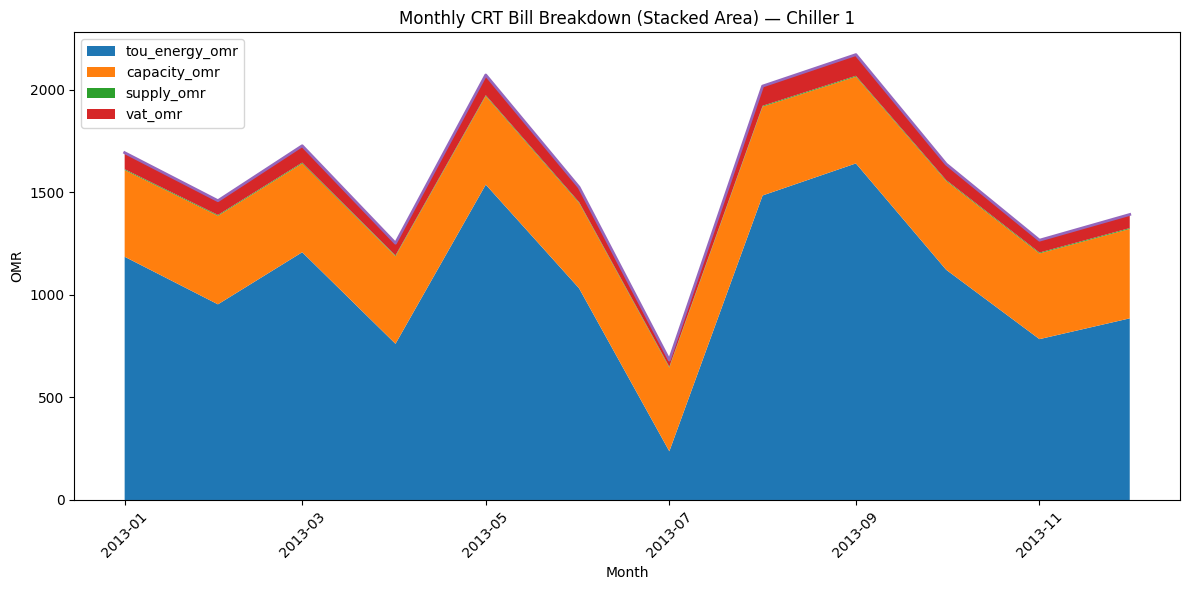

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

dfb = monthly_bill_ch1.copy()   # <-- change this name if yours is different

# Ensure month is datetime and sorted
dfb["month"] = pd.to_datetime(dfb["month"] + "-01")
dfb = dfb.sort_values("month").reset_index(drop=True)

components = ["tou_energy_omr", "capacity_omr", "supply_omr", "vat_omr"]
for c in components + ["total_bill_omr"]:
    dfb[c] = pd.to_numeric(dfb[c], errors="coerce").fillna(0.0)

plt.figure(figsize=(12, 6))
x = dfb["month"]
y = [dfb[c].values for c in components]

plt.stackplot(x, y, labels=components)
plt.plot(x, dfb["total_bill_omr"].values, linewidth=2)

plt.xlabel("Month")
plt.ylabel("OMR")
plt.title("Monthly CRT Bill Breakdown (Stacked Area) — Chiller 1")
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


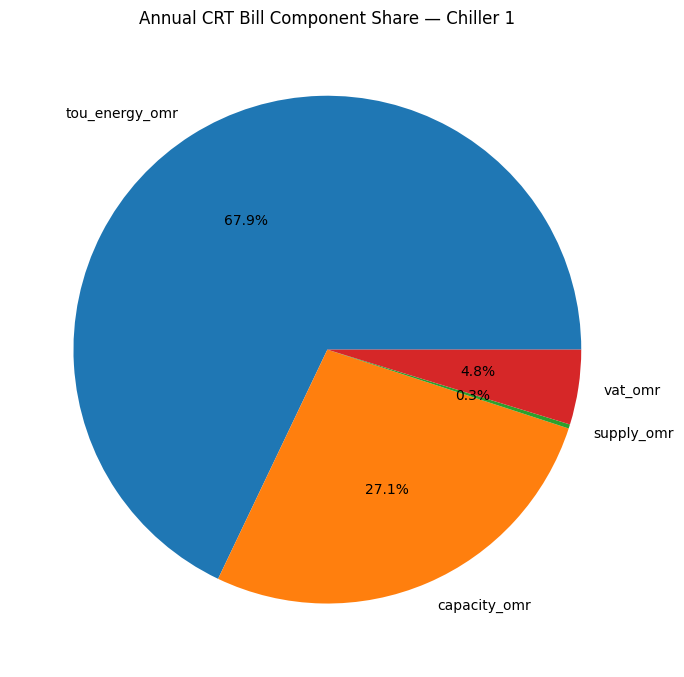

In [ ]:
import matplotlib.pyplot as plt

totals = dfb[["tou_energy_omr", "capacity_omr", "supply_omr", "vat_omr"]].sum()

plt.figure(figsize=(7, 7))
plt.pie(totals.values, labels=totals.index.tolist(), autopct="%1.1f%%")
plt.title("Annual CRT Bill Component Share — Chiller 1")
plt.tight_layout()
plt.show()


In [ ]:
summary = (totals / totals.sum() * 100).to_frame("share_pct")
summary["annual_omr"] = totals
summary = summary[["annual_omr", "share_pct"]]
summary


,annual_omr,share_pct
tou_energy_omr,12832.011979,67.919371
capacity_omr,5111.328722,27.054076
supply_omr,50.000000,0.264648
vat_omr,899.667035,4.761905


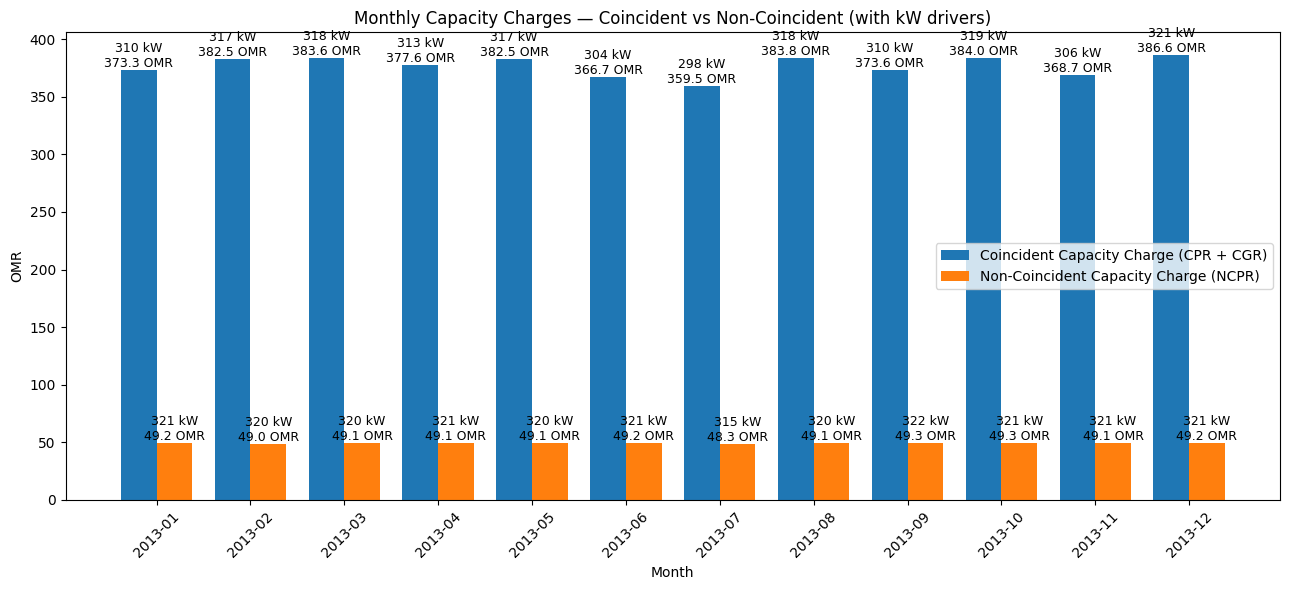

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

dfb = monthly_bill_ch1.copy()  # <- change name if your df is different

# Ensure month ordering
dfb["month_dt"] = pd.to_datetime(dfb["month"] + "-01")
dfb = dfb.sort_values("month_dt").reset_index(drop=True)

# Build the two cost series
dfb["coincident_capacity_omr"] = pd.to_numeric(dfb["capacity_cpr_omr"], errors="coerce").fillna(0.0) + \
                                 pd.to_numeric(dfb["capacity_cgr_omr"], errors="coerce").fillna(0.0)
dfb["noncoincident_capacity_omr"] = pd.to_numeric(dfb["capacity_ncpr_omr"], errors="coerce").fillna(0.0)

dfb["dc_kw"] = pd.to_numeric(dfb["dc_kw"], errors="coerce").fillna(0.0)
dfb["dnc_kw"] = pd.to_numeric(dfb["dnc_kw"], errors="coerce").fillna(0.0)

months = dfb["month"].tolist()
x = np.arange(len(months))
w = 0.38

plt.figure(figsize=(13, 6))

b1 = plt.bar(x - w/2, dfb["coincident_capacity_omr"].values, width=w, label="Coincident Capacity Charge (CPR + CGR)")
b2 = plt.bar(x + w/2, dfb["noncoincident_capacity_omr"].values, width=w, label="Non-Coincident Capacity Charge (NCPR)")

plt.xlabel("Month")
plt.ylabel("OMR")
plt.title("Monthly Capacity Charges — Coincident vs Non-Coincident (with kW drivers)")
plt.xticks(x, months, rotation=45)
plt.legend()

# Annotate each bar with kW + OMR
def annotate(bars, kw_series):
    for bar, kw in zip(bars, kw_series):
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h,
            f"{kw:.0f} kW\n{h:.1f} OMR",
            ha="center",
            va="bottom",
            fontsize=9
        )

annotate(b1, dfb["dc_kw"].values)
annotate(b2, dfb["dnc_kw"].values)

plt.tight_layout()
plt.show()
